# Reading the Data

In [1]:
#import de libs que usamos para leer y procesar datos en masa
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import numpy as np
import pandas as pd

#lib que usamos para mostrar las imagenes
import matplotlib.pyplot as plt
import seaborn as sns

# de python, para especificar rutas de archivos y directorios
from pathlib import Path

#libs para tareas generales de machine learning > separar datos, evaluar exactitud
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix

#libs para construir y entrenar redes neuronales
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution2D, MaxPooling2D, Flatten
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

import tensorflow as tf

2024-07-18 18:43:51.685259: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-18 18:43:51.685400: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-18 18:43:51.848433: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
%matplotlib inline

In [3]:
PARTS = "eye", "mouth"

TRAIN_DIR = Path("/kaggle/input/eye-vs-mouth-olivetti-faces-dataset/training_set")
VALIDATION_DIR = Path('/kaggle/input/eye-vs-mouth-olivetti-faces-dataset/test_set')
SIZE = 32

In [4]:
images_reader = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=(0.5, 1.5),
    horizontal_flip=True,
    #vertical_flip=True,
)

READ_PARAMS = dict(
    class_mode="categorical",  # tenemos N labels, queremos tuplas de 0s y 1s indicando cuál de los labels es
    classes=PARTS,  # para usar el mismo orden en todos lados
    target_size=(SIZE, SIZE),  # para que corra más rápido, vamos a achicar las imágenes
    color_mode="grayscale",  # queremos trabajar con las imágenes sin color
)

In [5]:
train = images_reader.flow_from_directory(TRAIN_DIR, **READ_PARAMS)
validation = images_reader.flow_from_directory(VALIDATION_DIR, **READ_PARAMS)

Found 399 images belonging to 2 classes.
Found 108 images belonging to 2 classes.


In [6]:
def sample_images(dataset):
    plt.figure(figsize=(10, 10))
    images, labels = next(dataset)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(PARTS[np.argmax(labels[i])])
        plt.axis("off")

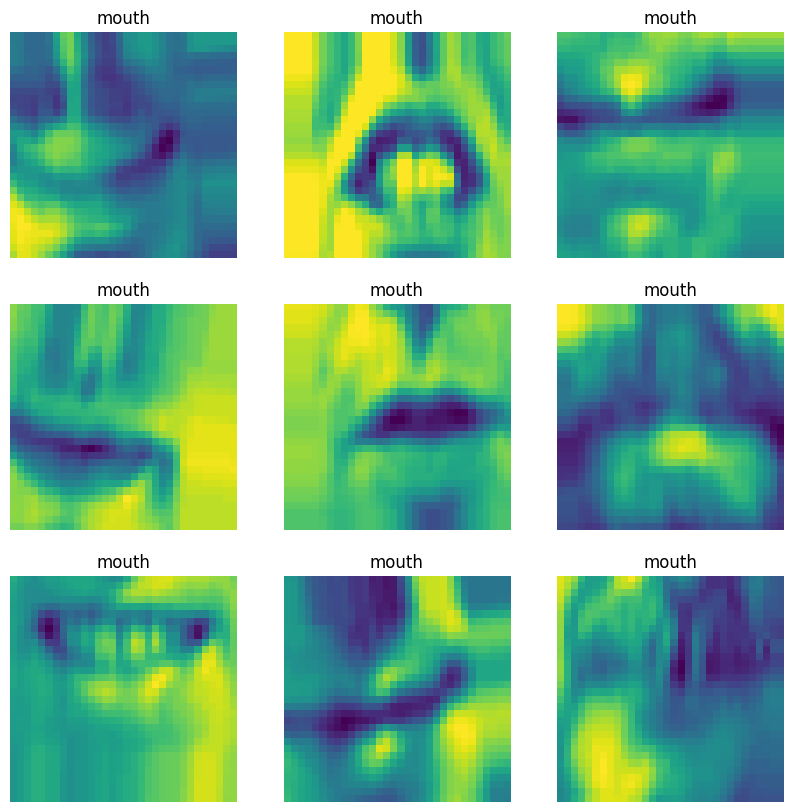

In [7]:
sample_images(train)

# Red Neuronal

In [8]:
input_shape = (SIZE, SIZE, 1) #1 por el grayscale

In [30]:
#MLP Simple
model_mlp = Sequential([
    Input(input_shape),
    Flatten(),

    Dense(500, activation='tanh'), #act method
    Dropout(0.25), #cancel overfitting
    
    Dense(len(PARTS), activation='softmax'), # probabilidades que sumen a 1 y la salida es la cantidad de categorias
])

In [31]:
model_mlp.compile(
    optimizer='adam', #Descenso por el gradiente
    loss='categorical_crossentropy', #funcion de error
    metrics=['accuracy'], 
)

In [32]:
model_mlp.summary(line_length=80)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                      ┃ Output Shape             ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)               │ (None, 1024)             │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_8 (Dense)                   │ (None, 500)              │       512,500 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dropout_5 (Dropout)               │ (None, 500)              │             0 │
├───────────────────────────────────┼──────────────────────────┼───────────────┤
│ dense_9 (Dense)                   │ (None, 2)                │         1,002 │
└───────────────────────────────────┴──────────────────────────┴───────────────┘

 Total params: 513,502 (1.96 MB)

 Trainable params: 513,502 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
model_weights_at_epochs = {}

class OurCustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        model_weights_at_epochs[epoch] = self.model.get_weights()

In [35]:
history = model_mlp.fit(
    train,
    epochs=20, #pasadas por todo el dataset
    batch_size=128, #cada 128 ajusta peso
    validation_data=validation,
    callbacks=[OurCustomCallback()]
)

Epoch 1/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.7979 - loss: 0.4655 - val_accuracy: 0.8519 - val_loss: 0.3928
Epoch 2/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8514 - loss: 0.3848 - val_accuracy: 0.9444 - val_loss: 0.2786
Epoch 3/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8909 - loss: 0.2845 - val_accuracy: 0.9074 - val_loss: 0.2591
Epoch 4/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8921 - loss: 0.3146 - val_accuracy: 0.8981 - val_loss: 0.2581
Epoch 5/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8791 - loss: 0.2842 - val_accuracy: 0.8704 - val_loss: 0.3298
Epoch 6/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8927 - loss: 0.2786 - val_accuracy: 0.8889 - val_loss: 0.2620
Epoch 7/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8927 - loss: 0.2927 - val_accuracy: 0.8611 - val_loss: 0.4488
Epoch 8/20
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8695 - loss: 0.3579 - val_accuracy: 0.8889 - v

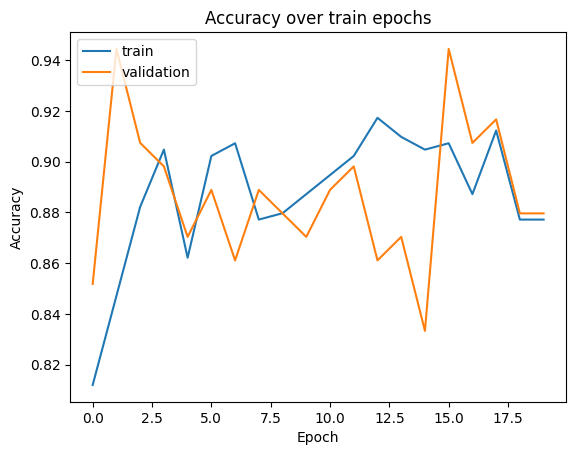

In [36]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy over train epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

In [37]:
model_mlp.set_weights(model_weights_at_epochs[16])

Found 399 images belonging to 2 classes.
Found 108 images belonging to 2 classes.
######################### train #########################
Samples: 399
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Accuracy: 0.924812030075188


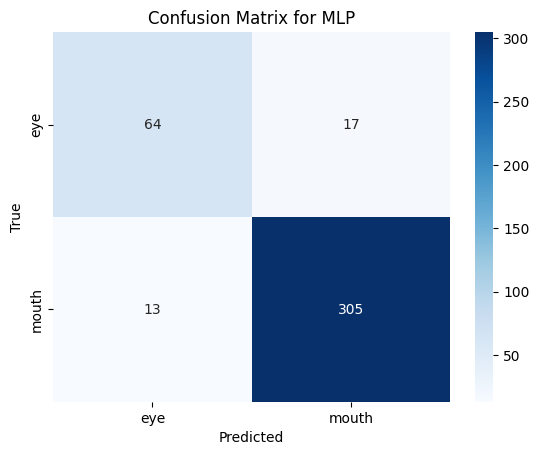

######################### validation #########################
Samples: 108
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Accuracy: 0.9444444444444444


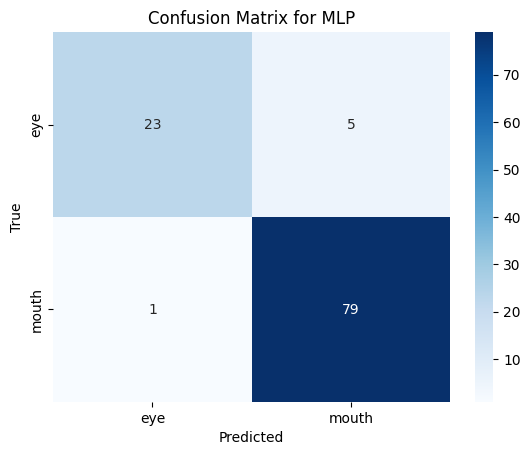

In [41]:
datasets = (
    ('train', images_reader.flow_from_directory(TRAIN_DIR, **READ_PARAMS, batch_size=1000)),
    ('validation', images_reader.flow_from_directory(VALIDATION_DIR, **READ_PARAMS, batch_size=1000)),
)

for dataset_name, dataset in datasets:
    print('#' * 25, dataset_name, '#' * 25)

    batch_images, batch_labels = next(dataset)
    print('Samples:', len(batch_images))

    predictions = np.argmax(model_mlp.predict(batch_images), axis=-1)
    labels = np.argmax(batch_labels, axis=-1)
    
    print('Accuracy:', accuracy_score(labels, predictions))

    cm = metrics.confusion_matrix(labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=PARTS, yticklabels=PARTS)
    #fmt=short numbers annot=True Mostrar numeros
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for MLP')
    plt.show()